In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("/content/train_spam.csv") # this part was writen in collab
test = pd.read_csv("/content/test_spam.csv")
train.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


<Axes: >

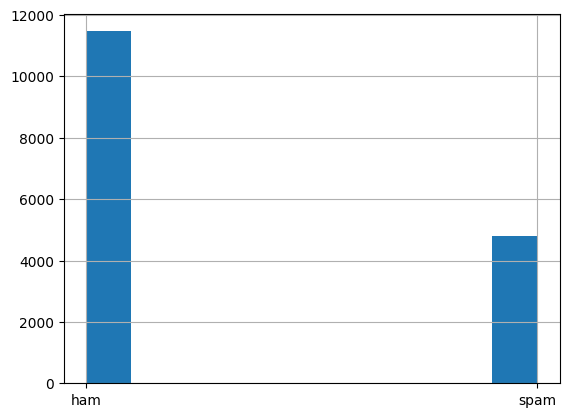

In [3]:
train["text_type"].hist() # target value distribution

Имеем в наличии достаточно маленький датасет, причем с дизбалансом классов.

# Preprocessing

In [4]:
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...

[nltk_data]   Package punkt is already up-to-date!

[nltk_data] Downloading package stopwords to /root/nltk_data...

[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def preprocess(sentence): # препроцессинг, убираем ненужные токены, собираем предложение обратно
    sent = [x.lower() for x in sent_tokenize(sentence) if x not in string.punctuation and x not in stopwords.words('english')]
    return " ".join(sent)

# CatBoost
в качестве бейслайн модели можно использовать бустинг. Он неплохо справляется с классификацией текстов и его быстро обучить (идеальный cold start)

In [6]:
train["normalized_text"] = train["text"].apply(preprocess)
test["normalized_text"] = test["text"].apply(preprocess)

Для бустинга придется преобразовать текст в более понятный для модели численный эмбеддинг. В целом, самым простым вариантом для векторизации является Tf-Idf, но это довольно неинформативный для модели (но интерпретируемый для нас) метод. Неплохим вариантом является использование pre-trained моделей для построения эмбеддингов текста.

In [7]:
!pip install -U sentence-transformers

In [8]:
import torch
from sentence_transformers import SentenceTransformer
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model = SentenceTransformer('all-MiniLM-L6-v2').to(device)
model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 

The secret `HF_TOKEN` does not exist in your Colab secrets.

To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.

You will be able to reuse this secret in all of your notebooks.

Please note that authentication is recommended but still optional to access public models or datasets.

  warnings.warn(


In [9]:
# %%capture
embeddings = model.encode(train["normalized_text"]) # this can take a while

In [10]:
!pip install -U catboost

In [11]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

X, y = embeddings, train["text_type"].replace({"ham": 0, "spam": 1})

X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.05) # маленький датасет :((

model = CatBoostClassifier(n_estimators=250, eval_metric='F1', task_type='GPU')
model.fit(X_train, y_train)

Learning rate set to 0.100417

0:	learn: 0.6974266	total: 27.4ms	remaining: 6.81s

1:	learn: 0.7038278	total: 42.2ms	remaining: 5.23s

2:	learn: 0.7165865	total: 60.2ms	remaining: 4.96s

3:	learn: 0.7241507	total: 74.8ms	remaining: 4.6s

4:	learn: 0.7212373	total: 91ms	remaining: 4.46s

5:	learn: 0.7258492	total: 106ms	remaining: 4.3s

6:	learn: 0.7378738	total: 126ms	remaining: 4.39s

7:	learn: 0.7490918	total: 141ms	remaining: 4.26s

8:	learn: 0.7543684	total: 168ms	remaining: 4.5s

9:	learn: 0.7560823	total: 193ms	remaining: 4.63s

10:	learn: 0.7638803	total: 207ms	remaining: 4.51s

11:	learn: 0.7684093	total: 220ms	remaining: 4.36s

12:	learn: 0.7754190	total: 232ms	remaining: 4.23s

13:	learn: 0.7787129	total: 244ms	remaining: 4.12s

14:	learn: 0.7824687	total: 257ms	remaining: 4.02s

15:	learn: 0.7886769	total: 269ms	remaining: 3.93s

16:	learn: 0.7907378	total: 281ms	remaining: 3.85s

17:	learn: 0.7928703	total: 296ms	remaining: 3.81s

18:	learn: 0.7992165	total: 308ms	remaining

In [12]:
from sklearn.metrics import roc_auc_score
pred = model.predict(X_val)

print(f"eval metrics with boosing: ROC-AUC: {roc_auc_score(y_val, pred)}")

eval metrics with boosing: ROC-AUC: 0.9282618482598642


```eval metrics with boosing: ROC-AUC: 0.9282618482598642```

Думаю, можно получить еще лучший скор, перебрав гиперпараметры по сетке. В целом это даст какой-то прирост, но, думаю, следующая модель в любом случае побьет бейслайн.

# BERT

In [2]:
!pip install transformers -U
!pip install transformers[torch]
# !pip install accelerate -U

In [14]:
# !transformers-cli env # if smth doesn't work

In [3]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_).to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# lets read data once more time
from sklearn.model_selection import train_test_split
train = pd.read_csv("/kaggle/input/spam-dataset/train_spam.csv")
test = pd.read_csv("/kaggle/input/spam-dataset/test_spam.csv")

X_train, y_train = list(train["text"]), list(train["text_type"].replace({"ham": 0, "spam": 1}))
X_test = test["text"]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle=True, random_state=42, test_size=0.05)

/tmp/ipykernel_1108/3444438481.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train, y_train = list(train["text"]), list(train["text_type"].replace({"ham": 0, "spam": 1}))


In [8]:
X_train_embeddings = tokenizer(X_train, max_length=256, padding = "max_length", truncation=True)
X_val_embeddings = tokenizer(X_val, max_length=256, padding = "max_length", truncation=True)

In [9]:
class Dataset(torch.utils.data.Dataset):
    """
    Custom PyTorch Dataset for handling input encodings and labels.

    Args:
        encodings (dict): A dictionary containing the input encodings (e.g., input_ids, attention_mask).
        labels (list, optional): List of labels corresponding to each input. Set to None for inference.

    Returns:
        item (dict): A dictionary containing the tensors for each input encoding and labels (if provided).
    """

    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Get an item from the dataset at the specified index.

        Args:
            idx (int): Index of the item to retrieve.

        Returns:
            item (dict): A dictionary containing the tensors for each input encoding and labels (if provided).
        """
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Get the total number of samples in the dataset.

        Returns:
            int: Total number of samples in the dataset.
        """
        return len(self.encodings["input_ids"])

In [10]:
train_dataset = Dataset(X_train_embeddings, y_train)
val_dataset = Dataset(X_val_embeddings, y_val)

In [12]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def calc_metrics(v): # just for eval
    predicted, labels = v
    predicted = np.argmax(predicted, axis=1)
    return f"roc-auc-score: {roc_auc_score(labels, predicted)}"

args = TrainingArguments(output_dir='./train_info', num_train_epochs=3, per_device_train_batch_size=64, logging_steps=300) # P100 16 gb => >64 batch size?

trainer = Trainer(model=model, train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=calc_metrics,
    args = args)

In [13]:
trainer.train()

wandb: Currently logged in as: m4xig1 (hse-m4xig1). Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.136000
1000,0.041200


TrainOutput(global_step=1452, training_loss=0.06546015614648824, metrics={'train_runtime': 1112.384, 'train_samples_per_second': 41.705, 'train_steps_per_second': 1.305, 'total_flos': 6103124040130560.0, 'train_loss': 0.06546015614648824, 'epoch': 3.0})

In [44]:
val_dataset = Dataset(X_val_embeddings)
eval_trainer = Trainer(model=model,
    eval_dataset=val_dataset,
    args = args)

pred = eval_trainer.predict(val_dataset)

In [77]:
print(f"eval metrics with BERT classifier: ROC-AUC: {roc_auc_score(y_val, pred.predictions[:, 1])}")

eval metrics with BERT classifier: ROC-AUC: 0.9964441867030895


```eval metrics with BERT classifier: ROC-AUC: 0.9964441867030895```
Как и ожидалось, BERT отлично справляется с задачей. Думаю, если продолжить дообучение, можно еще чуть-чуть увеличить ROC-AUC. 
BERT достаточно тяжелая модель, меня не покидает ощущение, что это оверкилл для такой простой задачи. Думаю, сравнительно похожий скор можно получить, если обучить нейронную сеть с несколькими полносвязными слоями, до этого можно преобразовать текст в эмбеддинги также, как мы делали с бустингом. Честно говоря, у меня осталось мало времени на эксперименты, оставим все как есть. 

In [68]:
test_dataset = Dataset(tokenizer(list(X_test.values), max_length=256, padding = "max_length", truncation=True))
test_pred = eval_trainer.predict(test_dataset).predictions[:, 1]
test_pred

array([-4.884435 , -4.497536 , -4.7282176, ..., -4.441855 , -4.4818225,
       -4.840178 ], dtype=float32)

In [80]:
final = pd.DataFrame({"score": test_pred, "text": X_test.values})
final.to_csv("./test_predictions.csv", index=False)
final.head()

,score,text
0,-4.884435,j jim whitehead ejw cse ucsc edu writes j you ...
1,-4.497536,original message from bitbitch magnesium net p...
2,-4.728218,java for managers vince durasoft who just taug...
3,-4.543067,there is a youtuber name saiman says
4,3.479783,underpriced issue with high return on equity t...
